In [1]:
import os

os.environ["OMP_NUM_THREADS"] = '12'

import torch
import torch.nn
import os.path as osp
import GCL.losses as L
import matplotlib.pyplot as plt
import GCL.augmentors as A
import numpy as np
import scipy.sparse as sp
import torch.nn.functional as F
import math
import functional as func

from torch import nn, tensor
from tqdm import tqdm
from torch.optim import Adam

from scipy.io import loadmat
from dgl.nn.pytorch import GATConv, GraphConv, GATv2Conv

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from munkres import Munkres, print_matrix
from sklearn import metrics
from GCL.models import DualBranchContrast, WithinEmbedContrast

from GCL.augmentors.augmentor import Graph, Augmentor
from GCL.augmentors.functional import dropout_adj
from GCL.augmentors.augmentor import Graph, Augmentor
from GCL.augmentors.functional import dropout_feature
from torch_geometric.utils import dropout_adj, degree, to_undirected


In [2]:
import dgl
import dgl.function as fn
import dgl.nn.pytorch as dglnn
from dgl.utils import expand_as_pair


class GConv(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super(GConv, self).__init__()
        self.act = nn.ELU()
        self.num_layers = num_layers
        self.norm = nn.BatchNorm1d(input_dim)
        self.dropout = nn.Dropout(0.5)
        self.layers = nn.ModuleList()
        # self.layers.append(
        #     MyGATConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True, num_heads=num_heads,
        #               residual=False, feat_drop=0.5, attn_drop=0.5)
        # )
        # for _ in range(1, num_layers):
        #     self.layers.append(
        #         MyGATConv(in_feats=num_heads * hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True,
        #                   num_heads=num_heads, residual=False, feat_drop=0.5, attn_drop=0.5)
        #     )
        self.layers.append(
            GraphConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True, norm='left')
        )
        for _ in range(1, num_layers):
            self.layers.append(
                GraphConv(in_feats=hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True, norm='left')
            )
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

    def forward(self, x, graph, edge_weight=None):
        z = x
        # attn = None
        # z = self.norm(z)

        for i in range(self.num_layers):
            # z, attn = self.layers[i](graph, z, attn)
            # z = self.layers[i](graph, z, edge_weight=edge_weight)
            # z = self.dropout(z)
            z = self.layers[i](graph, z)
            # z = z.flatten(1)
            z = self.act(z)
            # z = self.norm(z)

        # z = z / (torch.max(torch.norm(z, dim=1, keepdim=True), self.epsilon))
        # z = self.layers[-1](graph, z)
        return z


class Self_SupConLoss(nn.Module):
    def __init__(self, temperature=0.07, contrast_mode='all', base_temperature=0.07):
        super(Self_SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))
        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        # print(exp_logits.shape)
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()
        return loss


In [3]:
def cluster_acc(y_true, y_pred):
    y_true = y_true - np.min(y_true)

    l1 = list(set(y_true))
    numclass1 = len(l1)

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    ind = 0
    if numclass1 != numclass2:
        for i in l1:
            if i in l2:
                pass
            else:
                y_pred[ind] = i
                ind += 1

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    if numclass1 != numclass2:
        print('error')
        return

    cost = np.zeros((numclass1, numclass2), dtype=int)
    for i, c1 in enumerate(l1):
        mps = [i1 for i1, e1 in enumerate(y_true) if e1 == c1]
        for j, c2 in enumerate(l2):
            mps_d = [i1 for i1 in mps if y_pred[i1] == c2]
            cost[i][j] = len(mps_d)

    # match two clustering results by Munkres algorithm
    m = Munkres()
    cost = cost.__neg__().tolist()
    indexes = m.compute(cost)

    # get the match results
    new_predict = np.zeros(len(y_pred))
    for i, c in enumerate(l1):
        # correponding label in l2:
        c2 = l2[indexes[i][1]]

        # ai is the index with label==c2 in the pred_label list
        ai = [ind for ind, elm in enumerate(y_pred) if elm == c2]
        new_predict[ai] = c

    acc = metrics.accuracy_score(y_true, new_predict)
    f1_macro = metrics.f1_score(y_true, new_predict, average='macro')
    precision_macro = metrics.precision_score(y_true, new_predict, average='macro')
    recall_macro = metrics.recall_score(y_true, new_predict, average='macro')
    f1_micro = metrics.f1_score(y_true, new_predict, average='micro')
    precision_micro = metrics.precision_score(y_true, new_predict, average='micro')
    recall_micro = metrics.recall_score(y_true, new_predict, average='micro')
    return acc, f1_macro



In [4]:

device = torch.device('cuda')
# path = osp.join(osp.pardir, 'datasets', 'DBLP')
#
# mat = loadmat(osp.join(path, 'DBLP4057_GAT_with_idx.mat'))
#
path = osp.join(osp.pardir, 'datasets', 'ACM')

mat = loadmat(osp.join(path, 'ACM3025.mat'))

# path = osp.join(osp.pardir, 'datasets', 'IMDB')
#
# mat = loadmat(osp.join(path, 'imdb5k.mat'))

print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'PAP', 'PLP', 'PMP', 'PTP', 'feature', 'label', 'test_idx', 'train_idx', 'val_idx'])


In [5]:
# print(mat['net_APCPA'])

In [6]:
# graph_dict = {}
# # for etype in ['net_APCPA']:
# for etype in ['PAP']:
#     # for etype in ['MDM']:
#     edge_index = []
#     for i in tqdm(range(len(mat[etype]))):
#         for j in range(len(mat[etype])):
#             if mat[etype][i][j] == 1:
#                 edge_index.append([i, j])
#     print(len(edge_index))
#     edge_index = tensor(edge_index, dtype=torch.long).t().contiguous()
#     graph = dgl.graph((edge_index[0], edge_index[1])).to(device)
#     graph.remove_self_loop()
#     graph.add_self_loop()
#
#     edge_index = torch.stack(graph.edges())
#     print(edge_index.size())

def load_graph(graph):
    n, _ = graph.shape

    # idx = np.array([i for i in range(n)], dtype=np.int32)
    # idx_map = {j: i for i, j in enumerate(idx)}
    # edges_unordered = data
    # edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
    #                  dtype=np.int32).reshape(edges_unordered.shape)
    edges = np.array(graph, dtype=np.int32)
    idx = edges.nonzero()  # (row, col)
    data = edges[idx]
    # adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
    #                     shape=(n, n), dtype=np.float32)
    adj = sp.coo_matrix((data, idx), shape=(n, n), dtype=np.float32)
    # build symmetric adjacency matrix
    # adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    # adj = adj + sp.eye(adj.shape[0])
    # adj = normalize(adj)
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    return adj


def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


adj = load_graph(mat['PAP']).to(device)
# print(np.load(osp.join(path, 'dblp_adj.npy')))
# adj = load_graph(np.load(osp.join(path, 'dblp_adj.npy'))).to(device)
graph = dgl.graph((adj._indices()[0], adj._indices()[1]), num_nodes=len(mat['PAP'])).to(device)
# graph = dgl.graph((adj._indices()[0], adj._indices()[1]), num_nodes=len(np.load(osp.join(path, 'dblp_adj.npy')))).to(device)
graph.remove_self_loop()
graph.add_self_loop()
edge_weight = adj._values()
edge_index = torch.stack(graph.edges())
print(graph)
print(adj)

Graph(num_nodes=3025, num_edges=29281,
      ndata_schemes={}
      edata_schemes={})
tensor(indices=tensor([[   0,    0,    0,  ..., 3024, 3024, 3024],
                       [   0,    8,   20,  ..., 2983, 2991, 3024]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       device='cuda:0', size=(3025, 3025), nnz=29281, layout=torch.sparse_coo)


In [7]:

from sklearn.decomposition import PCA

# x = tensor(mat['feature'], dtype=torch.float).to(device)
# pca = PCA(n_components=100)
# x = pca.fit_transform(mat['feature'])
# x = tensor(x, dtype=torch.float).to(device)
# y = torch.argmax(tensor(mat['label']), -1).to(device)

x = tensor(mat['feature'], dtype=torch.float).to(device)
y = torch.argmax(tensor(mat['label']), -1).to(device)

# x = pca.fit_transform(mat['features'])
# x = tensor(x, dtype=torch.float).to(device)
# y = torch.argmax(tensor(mat['label']), -1).to(device)

# x = tensor(np.load(osp.join(path, 'dblp_feat.npy')), dtype=torch.float).to(device)
# y = tensor(np.load(osp.join(path, 'dblp_label.npy'))).to(device)
print(x.size())


torch.Size([3025, 1870])


In [8]:
del mat


model have 714527 paramerters in total


(T): 0it [00:00, ?it/s]
(T): 100%|██████████| 500/500 [00:43<00:00, 11.48it/s, loss=20.5, con_loss=11.8, kl_loss=8.73]


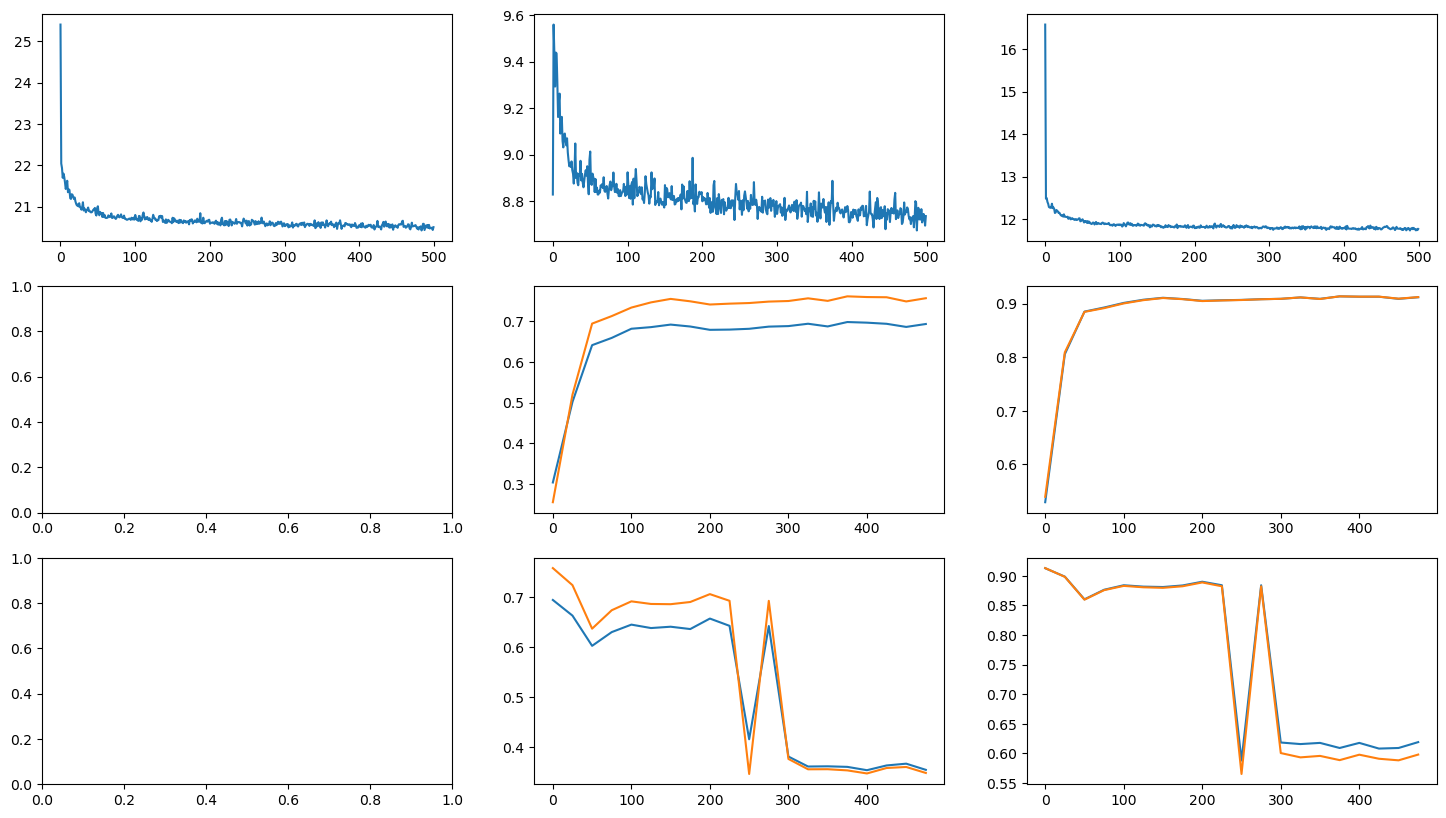

[MAX]ACC:  0.9127272727272727
[MAX]NMI:  0.6944106487048328
[MAX]ARI:  0.7580368714706697
[MAX]F1:  0.9129237458974009


In [33]:

class Encoder(nn.Module):
    def __init__(self, graph, augmentor, hidden_dim=256, proj_hidden_dim=128, n_clusters=3, num_layers=3):
        super(Encoder, self).__init__()

        self.encoder = GConv(input_dim=x.size(1), hidden_dim=hidden_dim, num_layers=num_layers).to(
            device)

        self.augmentor = augmentor
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

        self.cluster_layer = nn.Parameter(torch.Tensor(n_clusters, hidden_dim))
        self.v = 1
        self.device = torch.device('cuda')
        torch.nn.init.xavier_normal_(self.cluster_layer.data)

        self.instance_projector = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, proj_hidden_dim),
        )

        self.cluster_projector = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, n_clusters),
            nn.Softmax(dim=1)
        )

    def forward(self, x, graph, edge_index, edge_weight=None):
        aug1, aug2 = self.augmentor
        z = F.normalize(self.encoder(x, graph), dim=1)
        c = F.normalize(self.cluster_projector(z), dim=1)
        # z = self.decoder(z)

        x1, edge_index1, edge_weight1 = aug1(x, edge_index, edge_weight)
        graph1 = dgl.graph((edge_index1[0], edge_index1[1]), num_nodes=graph.num_nodes()).to(self.device)
        # graph1.remove_self_loop()
        # graph1.add_self_loop()
        z1 = F.normalize(self.encoder(x1, graph1, edge_weight1), dim=1)

        x2, edge_index2, edge_weight2 = aug2(x, edge_index, edge_weight)
        graph2 = dgl.graph((edge_index2[0], edge_index2[1]), num_nodes=graph.num_nodes()).to(self.device)
        # graph2.remove_self_loop()
        # graph2.add_self_loop()
        z2 = F.normalize(self.encoder(x2, graph2, edge_weight2), dim=1)

        c1 = F.normalize(self.cluster_projector(z1), dim=1)
        c2 = F.normalize(self.cluster_projector(z2), dim=1)

        z1 = self.instance_projector(z1)
        z2 = self.instance_projector(z2)

        return z, z1, z2, c1, c2, c


class AdaptiveFeatureDropout(Augmentor):
    def __init__(self, pf: float, threshold: float, w):
        super(AdaptiveFeatureDropout, self).__init__()
        self.pf = pf
        self.threshold = threshold
        self.w = w

    def augment(self, g: Graph) -> Graph:
        x, edge_index, edge_weights = g.unfold()
        w = self.w
        w = w / w.mean() * self.pf
        w = w.where(w < self.threshold, torch.ones_like(self.w) * self.threshold)
        drop_prob = w

        drop_mask = torch.bernoulli(drop_prob).to(torch.bool)

        x = x.clone()
        x[:, drop_mask] = 0.
        return Graph(x=x, edge_index=edge_index, edge_weights=edge_weights)


class AdaptiveEdgeRemoving(Augmentor):
    def __init__(self, pe: float, threshold: float, drop_weight):
        super(AdaptiveEdgeRemoving, self).__init__()
        self.pe = pe
        self.threshold = threshold
        self.drop_weight = drop_weight

    def augment(self, g: Graph) -> Graph:
        x, edge_index, _ = g.unfold()
        edge_weights = self.drop_weight
        edge_weight = edge_weights.mean()
        edge_weights = edge_weights / edge_weight * self.pe
        edge_weights = torch.sigmoid(edge_weights)
        edge_weights = edge_weights.where(edge_weights < self.threshold, torch.ones_like(edge_weights) * self.threshold)
        sel_mask = torch.bernoulli(1. - edge_weights).to(torch.bool)
        return Graph(x=x, edge_index=edge_index[:, sel_mask], edge_weights=edge_weights)


def train1(encoder_model, contrast_model, optimizer, x, graph, edge_index, edge_weight,
           clu_loss_func=DualBranchContrast(loss=L.InfoNCE(tau=0.5), mode='L2L', intraview_negs=True).to(device)):
    encoder_model.train()
    optimizer.zero_grad()
    _, z1, z2, c1, c2, _ = encoder_model(x, graph, edge_index, edge_weight)
    # embeddings = torch.cat([z1.unsqueeze(1), z2.unsqueeze(1)], dim=1)
    # con_loss = contrast_model(embeddings)
    con_loss = contrast_model(z1, z2)
    loss = con_loss
    # loss = con_loss

    loss.backward()
    optimizer.step()
    return loss.item(), con_loss.item()


def train2(encoder_model, contrast_model, optimizer, x, graph, edge_index, edge_weight,
           clu_loss_func=DualBranchContrast(loss=L.InfoNCE(tau=0.1), mode='L2L', intraview_negs=True).to(device)):
    encoder_model.train()
    optimizer.zero_grad()
    _, z1, z2, c1, c2, _ = encoder_model(x, graph, edge_index, edge_weight)
    # embeddings = torch.cat([z1.unsqueeze(1), z2.unsqueeze(1)], dim=1)
    # con_loss = contrast_model(embeddings)
    con_loss = contrast_model(z1, z2)
    # con_loss = F.mse_loss(torch.matmul(z1, z2.T), torch.eye(z1.size(0)).to('cuda'))

    # clu_loss = clu_loss_func(c1.t(), c2.t()) + clu_loss_func(c1, c2)
    clu_loss = clu_loss_func(c1.t(), c2.t()) + clu_loss_func(c1, c2)
    # clu_loss = 0.01 * contrast_model(c1.t(), c2.t())
    # con_loss = 0.01 * con_loss
    loss = con_loss + clu_loss
    # loss = con_loss + clu_loss

    loss.backward()
    optimizer.step()
    return loss.item(), con_loss.item(), clu_loss.item()


def train3(encoder_model, contrast_model, optimizer, x, graph, edge_index, edge_weight, c,
           clu_loss_func=DualBranchContrast(loss=L.InfoNCE(tau=0.1), mode='L2L', intraview_negs=True).to(device)):
    encoder_model.train()
    optimizer.zero_grad()
    _, z1, z2, c1, c2, _ = encoder_model(x, graph, edge_index, edge_weight)
    plabel = torch.argmax(c, dim=1)
    mask = torch.gt(torch.max(c, dim=1).values, 0.5)
    extra_pos_mask = torch.eq(plabel, plabel.unsqueeze(dim=1)).to('cuda')
    # construct extra supervision signals for only training samples
    # extra_pos_mask[~mask][:, ~mask] = False
    extra_pos_mask.fill_diagonal_(False)
    # pos_mask: [N, 2N] for both inter-view and intra-view samples
    extra_pos_mask = torch.cat([extra_pos_mask, extra_pos_mask], dim=1).to('cuda')
    # fill interview positives only; pos_mask for intraview samples should have zeros in diagonal
    extra_pos_mask.fill_diagonal_(True)

    extra_neg_mask = torch.ne(plabel, plabel.unsqueeze(dim=1)).to('cuda')
    # extra_neg_mask[~mask][:, ~mask] = True
    extra_neg_mask.fill_diagonal_(False)
    extra_neg_mask = torch.cat([extra_neg_mask, extra_neg_mask], dim=1).to('cuda')

    con_loss = contrast_model(h1=z1, h2=z2, extra_pos_mask=extra_pos_mask, extra_neg_mask=extra_neg_mask)
    # embeddings = torch.cat([z1.unsqueeze(1), z2.unsqueeze(1)], dim=1)
    # con_loss = contrast_model(embeddings)
    # clu_loss = clu_loss_func(c1.t(), c2.t()) + clu_loss_func(c1, c2)
    clu_loss = clu_loss_func(c1.t(), c2.t()) + clu_loss_func(c1, c2)
    loss = con_loss + clu_loss

    loss.backward()
    optimizer.step()
    return loss.item(), con_loss.item(), clu_loss.item()


drop_weight = func.degree_drop_weights(edge_index).to(device)
edge_index_ = to_undirected(edge_index)
node_degree = degree(edge_index_[1])
feature_weight = func.feature_drop_weights(x, node_c=node_degree).to(device)

# aug1 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureDropout(pf=0.5)])
# # aug1 = A.Identity()
# aug2 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureDropout(pf=0.5)])
aug1 = A.Compose([AdaptiveEdgeRemoving(pe=0.7, threshold=0.7, drop_weight=drop_weight), AdaptiveFeatureDropout(pf=0.7, threshold=0.7, w=feature_weight)])
aug2 = A.Compose([AdaptiveEdgeRemoving(pe=0.8, threshold=0.7, drop_weight=drop_weight), AdaptiveFeatureDropout(pf=0.8, threshold=0.7, w=feature_weight)])
# aug1 = A.Compose([A.EdgeRemoving(pe=0.3), AdaptiveFeatureDropout(pf=0.3, threshold=0.7, w=feature_weight)])
# aug2 = A.Compose([A.EdgeRemoving(pe=0.3), AdaptiveFeatureDropout(pf=0.3, threshold=0.7, w=feature_weight)])
encoder_model = Encoder(graph=graph, augmentor=(aug1, aug2), hidden_dim=256, proj_hidden_dim=128, n_clusters=3,
                        num_layers=2).to(device)

print("model have {} paramerters in total".format(sum(x.numel() for x in encoder_model.parameters())))

contrast_model = DualBranchContrast(loss=L.InfoNCE(tau=0.1), mode='L2L', intraview_negs=True).to(device)
# contrast_model = Self_SupConLoss(temperature=0.1)
cluster_model = DualBranchContrast(loss=L.InfoNCE(tau=0.1), mode='L2L', intraview_negs=True).to(device)

optimizer1 = Adam(encoder_model.parameters(), lr=0.0001)
optimizer = Adam(encoder_model.parameters(), lr=0.0003, weight_decay=1e-05)
losss = []
kl_losss = []
con_losss = []
nmis = []
aris = []
ratios = []
accs = []
f1s = []
epochs1 = 0
epochs2 = 500
epochs3 = 500

kmeans = KMeans(n_clusters=3, n_init=16)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 10))

with tqdm(total=epochs1, desc='(T)') as pbar:
    for epoch in range(epochs1):
        encoder_model.train()
        # if epoch % 1 == 0:
        #     # update_interval
        #     _, _, _, tmp_q = encoder_model(x, graph, edge_index)
        #
        #     p = target_distribution(tmp_q.data)

        loss, con_loss = train1(encoder_model, contrast_model,
                                optimizer1, x, graph, edge_index,
                                edge_weight)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss})
        pbar.update()

with tqdm(total=epochs2, desc='(T)') as pbar:
    for epoch in range(epochs2):
        encoder_model.train()
        # if epoch % 1 == 0:
        #     # update_interval
        #     _, _, _, tmp_q = encoder_model(x, graph, edge_index)
        #
        #     p = target_distribution(tmp_q.data)

        loss, con_loss, kl_loss = train2(encoder_model, contrast_model, optimizer, x, graph, edge_index, edge_weight,
                                         clu_loss_func=cluster_model)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss, 'kl_loss': kl_loss})
        pbar.update()

        if epoch % 25 == 0:
            with torch.no_grad():
                encoder_model.eval()
                z, _, _, _, _, _ = encoder_model(x, graph, edge_index, edge_weight)
            pred = kmeans.fit_predict(z.cpu())
            nmi = normalized_mutual_info_score(pred, y.cpu())
            ari = adjusted_rand_score(pred, y.cpu())
            nmis.append((epoch, nmi))
            aris.append((epoch, ari))
            acc, f1 = cluster_acc(y.cpu().numpy(), pred)
            accs.append((epoch, acc))
            f1s.append((epoch, f1))

axes[1][1].plot([i[0] for i in nmis], [i[1] for i in nmis])
axes[1][1].plot([i[0] for i in aris], [i[1] for i in aris])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in accs])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in f1s])

with torch.no_grad():
    encoder_model.eval()
    z, _, _, _, _, c = encoder_model(x, graph, edge_index, edge_weight)
# pred = kmeans.fit_predict(z.cpu())
# plabel = torch.argmax(c, -1)
# contrast_model = Self_SupConLoss(temperature=0.5)
losss = []
kl_losss = []
con_losss = []
nmis = []
aris = []
ratios = []
accs = []
f1s = []
with tqdm(total=epochs3, desc='(T)') as pbar:
    optimizer = Adam(encoder_model.parameters(), lr=0.001)
    for epoch in range(epochs3):
        encoder_model.train()
        # if epoch % 1 == 0:
        #     # update_interval
        #     _, _, _, tmp_q = encoder_model(x, graph, edge_index)
        #
        #     p = target_distribution(tmp_q.data)

        loss, con_loss, kl_loss = train3(encoder_model, contrast_model, optimizer, x, graph, edge_index, edge_weight,
                                         c,
                                         clu_loss_func=cluster_model)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss, 'kl_loss': kl_loss})
        pbar.update()
        losss.append(loss)
        kl_losss.append(kl_loss)
        con_losss.append(con_loss)
        ratios.append((100 * kl_loss) / loss)

        if epoch % 10 == 0:
            with torch.no_grad():
                encoder_model.eval()
                z, _, _, _, _, c = encoder_model(x, graph, edge_index, edge_weight)
            # plabel = torch.argmax(c, -1)

        if epoch % 25 == 0:
            with torch.no_grad():
                encoder_model.eval()
                z, _, _, _, _, _ = encoder_model(x, graph, edge_index, edge_weight)
            pred = kmeans.fit_predict(z.cpu())
            nmi = normalized_mutual_info_score(pred, y.cpu())
            ari = adjusted_rand_score(pred, y.cpu())
            nmis.append((epoch, nmi))
            aris.append((epoch, ari))
            acc, f1 = cluster_acc(y.cpu().numpy(), pred)
            accs.append((epoch, acc))
            f1s.append((epoch, f1))

axes[0][0].plot(range(epochs3), losss)
axes[0][1].plot(range(epochs3), kl_losss)
axes[0][2].plot(range(epochs3), con_losss)
axes[2][1].plot([i[0] for i in nmis], [i[1] for i in nmis])
axes[2][1].plot([i[0] for i in aris], [i[1] for i in aris])
axes[2][2].plot([i[0] for i in aris], [i[1] for i in accs])
axes[2][2].plot([i[0] for i in aris], [i[1] for i in f1s])
plt.show()
print('[MAX]ACC: ', max([i[1] for i in accs]))
print('[MAX]NMI: ', max([i[1] for i in nmis]))
print('[MAX]ARI: ', max([i[1] for i in aris]))
print('[MAX]F1: ', max([i[1] for i in f1s]))
# test_result = test(encoder_model, data)
# print(f'(E): Best test F1Mi={test_result["micro_f1"]:.4f}, F1Ma={test_result["macro_f1"]:.4f}')


D:\Python\anaconda3\envs\black\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
D:\Python\anaconda3\envs\black\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


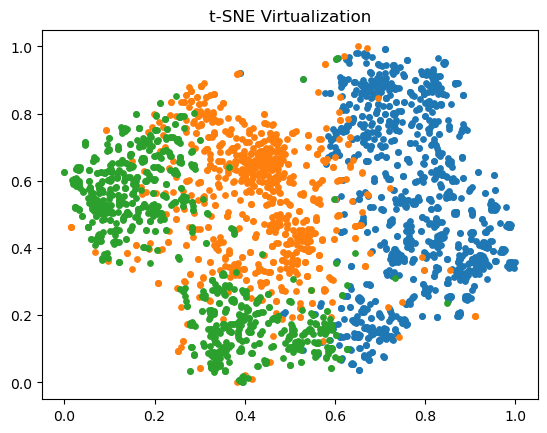

In [34]:
from sklearn import manifold, datasets

tsne = manifold.TSNE(n_components=2, init='pca')

with torch.no_grad():
    encoder_model.eval()
    z, _, _, _, _, _ = encoder_model(x, graph, edge_index, edge_weight)
    pred = kmeans.fit_predict(z.cpu())
X_tsne = tsne.fit_transform(z.cpu().numpy())
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

d = np.where(pred == 0)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 1)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 2)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 3)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)

plt.title('t-SNE Virtualization')
plt.show()

In [ ]:
d = np.where(y.cpu() == 0)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 1)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 2)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 3)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)

plt.title('t-SNE Virtualization')
plt.show()

In [ ]:

with torch.no_grad():
    encoder_model.eval()
    z, _, _, _, _, c = encoder_model(x, graph, edge_index, edge_weight)
pred = torch.argmax(c, dim=1).cpu().numpy()
nmi = normalized_mutual_info_score(pred, y.cpu())
ari = adjusted_rand_score(pred, y.cpu())
acc, f1 = cluster_acc(y.cpu().numpy(), pred)
print(acc, f1, nmi, ari)

In [ ]:

pred = kmeans.fit_predict(x.cpu())

nmi = normalized_mutual_info_score(pred, y.cpu())
print('[INFO]NMI: ', nmi)

ari = adjusted_rand_score(pred, y.cpu())
print('[INFO]ARI: ', ari)

In [ ]:
with torch.no_grad():
    encoder_model.eval()
    z, _, _, _, _, c = encoder_model(x, graph, edge_index, edge_weight)
# pred = kmeans.fit_predict(z.cpu())
plabel = torch.argmax(c, -1)
print(c)

In [ ]:
yy = tensor([[0.2, 0.3, 0.5],
             [0.5, 0.3, 0.2]])
mask = torch.gt(torch.max(yy, dim=1).values, 0.4)
print(mask)
